In [ ]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.0 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
from scipy.io import loadmat
from deepxde.backend import tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term



The test data is generated using the dataset taken from https://github.com/lululxvi/deepxde/blob/master/examples/dataset/Allen_Cahn.mat

In [ ]:
def gen_testdata():
  data = loadmat("Allen_Cahn.mat")

  t = data["t"]
  x = data["x"]
  u = data["u"]

  dt = dx = 0.01
  xx, tt = np.meshgrid(x, t)
  X = np.vstack((np.ravel(xx), np.ravel(tt))).T
  y = u.flatten()[:, None]
  return X, y, xx, tt, u

The PDE is an Allen-Cahn equation:

$u_t - d u_{xx} = 5 (u - u^3), \ x \in [-1,1], \ t \in [0,1]$ \\
$u(-1, t) = u(1, t) = -1, \ t \in [0, 1]$ \\
$u(x, 0) = x^2 \cos(\pi x), \ x \in [-1,1]$

The Dirichlet boundary condition and the initial condition are treated as hard costraints by applying the following output transformation:

$\hat{u}(x, t) = t (1 - x^2) u_{NN}(x, t) + x^2 \cos(\pi x)$

Indeed, $\hat{u}(-1, t) = \hat{u}(1, t) = -1$ and $\hat{u}(x, 0) = x^2 \cos(\pi x)$

In [ ]:
d = 0.001

def pde(x, y):
  dy_t = dde.grad.jacobian(y, x, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  return dy_t - d * dy_xx - 5 * (y - y**3)

def output_transform(x, y):
    return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

Plotting the reference solution

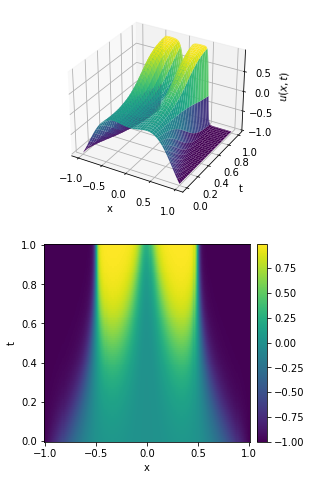

In [ ]:
X, y_true, x_mesh, t_mesh, u_mesh = gen_testdata()

fig = plt.figure(figsize=plt.figaspect(2.))

ax1 = fig.add_subplot(2, 1, 1, projection='3d')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_zlabel('$u(x,t)$')
ax1.plot_surface(x_mesh, t_mesh, u_mesh, cmap='viridis', edgecolor='none')

ax2 = fig.add_subplot(2, 1, 2)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
plot = ax2.pcolormesh(x_mesh, t_mesh, u_mesh, cmap='viridis')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot, cax=cax, orientation='vertical')

# PINN

Simple PINN with variable number of iterations and learning rate of the Adam optimizer, and variable number of training points. The model has 4 hidden layers with 20 neurons each. In the first example, the model is trained for 30000 iterations of the Adam optimizer (plus some iterations of L-BFGS) using 0.001 as learning rate and with 2000 points inside the domain, 200 points for the boundary condition and 200 points for the initial condition.

Compiling model...
Building feed-forward neural network...
'build' took 0.088510 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.080012 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [8.23e-01]    [8.23e-01]    []  
1000      [3.00e-02]    [3.00e-02]    []  
2000      [1.20e-02]    [1.20e-02]    []  
3000      [9.57e-03]    [9.57e-03]    []  
4000      [8.35e-03]    [8.35e-03]    []  
5000      [7.65e-03]    [7.65e-03]    []  
6000      [7.07e-03]    [7.07e-03]    []  
7000      [6.48e-03]    [6.48e-03]    []  
8000      [5.82e-03]    [5.82e-03]    []  
9000      [5.56e-03]    [5.56e-03]    []  
10000     [5.33e-03]    [5.33e-03]    []  
11000     [5.22e-03]    [5.22e-03]    []  
12000     [5.01e-03]    [5.01e-03]    []  
13000     [4.89e-03]    [4.89e-03]    []  
14000     [4.72e-03]    [4.72e-03]    []  
15000     [4.58e-03]    [4.58e-03]    []  
16000     [4.36e-03]    [4.36e-03]    []  
17000     [3.70e-03]    [3.70e-03]    []  
18000     [4.95e-03]    [4.95e-03]    []  
19000     [1.65e-03]    [1.65e-03]    []  
20000     [1.41e-0

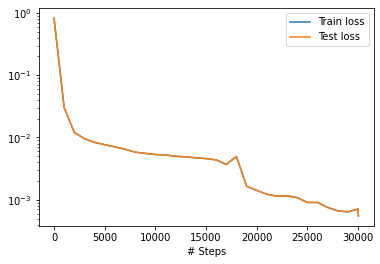

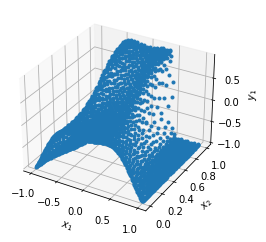

In [ ]:
def train_pinn(iterations_adam, lr, domain_points, bc_points, ic_points):
  geom = dde.geometry.Interval(-1, 1)
  timedomain = dde.geometry.TimeDomain(0, 1)
  geomtime = dde.geometry.GeometryXTime(geom, timedomain)

  data = dde.data.TimePDE(geomtime, pde, [], num_domain=domain_points, num_boundary=bc_points, num_initial=ic_points)
  net = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot normal")
  net.apply_output_transform(output_transform)
  model = dde.Model(data, net)

  model.compile("adam", lr=lr)
  model.train(iterations=iterations_adam)
  model.compile("L-BFGS")
  losshistory, train_state = model.train()
  return losshistory, train_state, model

losshistory, train_state, model = train_pinn(30000, 1e-3, 2000, 200, 200)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.017292252
L2 relative error: 0.13868527574369072


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area.

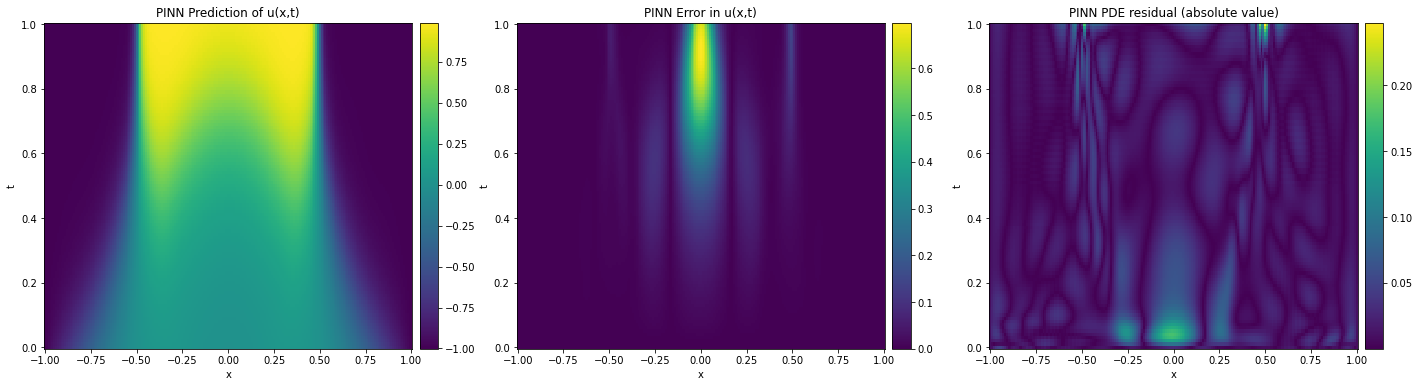

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
axs[0].set_title('PINN Prediction of u(x,t)')
plot1 = axs[0].pcolormesh(x_mesh, t_mesh, y_pred.reshape(x_mesh.shape), cmap='viridis')
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')

axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
axs[1].set_title('PINN Error in u(x,t)')
plot2 = axs[1].pcolormesh(x_mesh, t_mesh, np.absolute(y_true - y_pred).reshape(x_mesh.shape), cmap='viridis')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')

axs[2].set_xlabel('x')
axs[2].set_ylabel('t')
axs[2].set_title('PINN PDE residual (absolute value)')
plot3 = axs[2].pcolormesh(x_mesh, t_mesh, np.absolute(f).reshape(x_mesh.shape), cmap='viridis')
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot3, cax=cax3, orientation='vertical')

# RAR

Here I use RAR to improve the PINN solution. In the first example, a maximum number of 3 iterations is done, by adding each time 20 points.

Compiling model...
Building feed-forward neural network...
'build' took 0.080291 s

'compile' took 2.882872 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [8.13e-01]    [8.13e-01]    []  
1000      [1.15e-01]    [1.15e-01]    []  
2000      [1.97e-02]    [1.97e-02]    []  
3000      [1.23e-02]    [1.23e-02]    []  
4000      [1.06e-02]    [1.06e-02]    []  
5000      [9.66e-03]    [9.66e-03]    []  
6000      [8.94e-03]    [8.94e-03]    []  
7000      [8.44e-03]    [8.44e-03]    []  
8000      [7.85e-03]    [7.85e-03]    []  
9000      [7.46e-03]    [7.46e-03]    []  
10000     [7.05e-03]    [7.05e-03]    []  
11000     [6.80e-03]    [6.80e-03]    []  
12000     [7.22e-03]    [7.22e-03]    []  
13000     [6.49e-03]    [6.49e-03]    []  
14000     [6.08e-03]    [6.08e-03]    []  
15000     [5.78e-03]    [5.78e-03]    []  
16000     [5.61e-03]    [5.61e-03]    []  
17000     [5.23e-03]    [5.23e-03]    []  
18000     [5.28e-03]

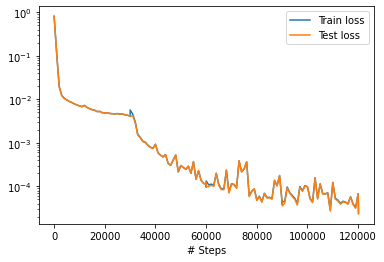

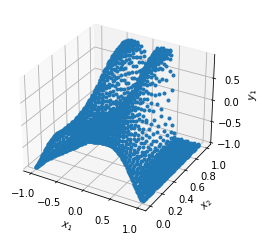

In [ ]:
def train_rar(iterations_adam, lr, domain_points, bc_points, ic_points,
              max_iterations_rar, threshold, m):
  geom = dde.geometry.Interval(-1, 1)
  timedomain = dde.geometry.TimeDomain(0, 1)
  geomtime = dde.geometry.GeometryXTime(geom, timedomain)

  data = dde.data.TimePDE(geomtime, pde, [], num_domain=domain_points, num_boundary=bc_points, num_initial=ic_points)
  net = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot normal")
  net.apply_output_transform(output_transform)
  model_rar = dde.Model(data, net)

  model_rar.compile("adam", lr=lr)
  model_rar.train(iterations=iterations_adam)
  model_rar.compile("L-BFGS")
  losshistory, train_state = model_rar.train()

  inputs = geomtime.random_points(10000)
  error = 10
  i = 0
  added_points = np.empty([0, 2])
  while error > threshold and i < max_iterations_rar:
    f_values = model_rar.predict(inputs, operator=pde)
    f_abs = np.absolute(f_values)
    error = np.mean(f_abs)
    print("mean error: ", error)

    top_m = np.argsort(f_abs.flatten())[::-1][:m]
    points_to_add = inputs[top_m]
    print("points added: ", points_to_add)
    data.add_anchors(points_to_add)
    added_points = np.vstack((added_points, points_to_add))

    model_rar.compile("adam", lr=lr)
    model_rar.train(iterations=iterations_adam, disregard_previous_best=True)
    model_rar.compile("L-BFGS")
    losshistory, train_state = model_rar.train()
    i += 1

  return losshistory, train_state, model_rar, added_points

losshistory, train_state, model_rar, added_points = train_rar(30000, 1e-3, 2000, 200, 200, 3, 0.0001, 20)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
y_pred = model_rar.predict(X)
f = model_rar.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.0038189713
L2 relative error: 0.02845676970258512


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area. In additon, the points that were added during the process are shown in the first plot

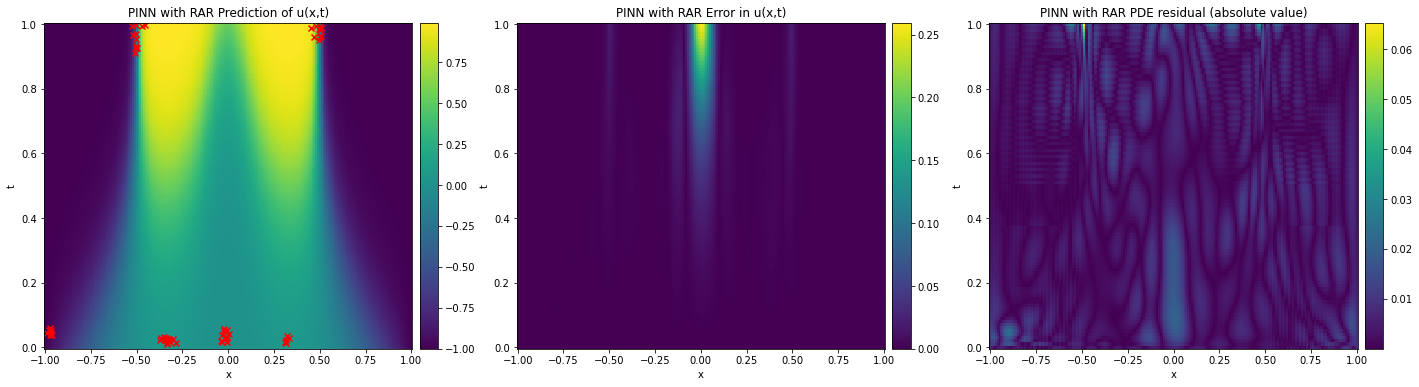

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
axs[0].set_title('PINN with RAR Prediction of u(x,t)')
plot1 = axs[0].pcolormesh(x_mesh, t_mesh, y_pred.reshape(x_mesh.shape), cmap='viridis')
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')
axs[0].scatter(added_points[:, 0], added_points[:, 1], color='r', marker='x')

axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
axs[1].set_title('PINN with RAR Error in u(x,t)')
plot2 = axs[1].pcolormesh(x_mesh, t_mesh, np.absolute(y_true - y_pred).reshape(x_mesh.shape), cmap='viridis')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')

axs[2].set_xlabel('x')
axs[2].set_ylabel('t')
axs[2].set_title('PINN with RAR PDE residual (absolute value)')
plot3 = axs[2].pcolormesh(x_mesh, t_mesh, np.absolute(f).reshape(x_mesh.shape), cmap='viridis')
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot3, cax=cax3, orientation='vertical')

# gPINN

In the gPINN (Gradient-enhanced PINN), the first derivative of the PDE is set to zero, and this is added to the loss function. In the DeepXDE library, this can be treated as if it is part of the PDE by adding the following two condions, that represent the gradient of the PDE:

$u_{tx} - d u_{xxx} = 5 (u_x - 3 u_x u^2)$ \\
$u_{tt} - d u_{xxt} = 5 (u_t - 3 u_t u^2)$

In [ ]:
def pde_gpinn(x, y):
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)

  dy_tt = dde.grad.hessian(y, x, i=1, j=1)
  dy_xxt = dde.grad.jacobian(dy_xx, x, i=0, j=1)

  dy_tx = dde.grad.hessian(y, x, i=1, j=0)
  dy_xxx = dde.grad.jacobian(dy_xx, x, i=0, j=0)
  dy_x = dde.grad.jacobian(y, x, i=0, j=0)

  return [
      dy_t - d * dy_xx - 5 * (y - y**3),
      dy_tx - d * dy_xxx - 5 * (dy_x - 3 * y**2 * dy_x),
      dy_tt - d * dy_xxt - 5 * (dy_t - 3 * y**2 * dy_t)
  ]

def output_transform_gpinn(X, y):
  x = X[:, 0:1]
  t = X[:, 1:2]
  return t * (1 + x) * (1 - x) * y + tf.square(x) * tf.cos(np.pi * x)

The model is trained using the same parameters of the PINN version.

Compiling model...
Building feed-forward neural network...
'build' took 0.076585 s

'compile' took 5.212811 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.87e-01, 4.20e-03, 1.35e-04]    [7.87e-01, 4.20e-03, 1.35e-04]    []  
1000      [7.52e-02, 7.37e-04, 1.57e-04]    [7.52e-02, 7.37e-04, 1.57e-04]    []  
2000      [1.89e-02, 2.68e-04, 5.41e-05]    [1.89e-02, 2.68e-04, 5.41e-05]    []  
3000      [1.20e-02, 2.10e-04, 3.71e-05]    [1.20e-02, 2.10e-04, 3.71e-05]    []  
4000      [1.04e-02, 1.70e-04, 3.37e-05]    [1.04e-02, 1.70e-04, 3.37e-05]    []  
5000      [9.38e-03, 1.57e-04, 3.42e-05]    [9.38e-03, 1.57e-04, 3.42e-05]    []  
6000      [8.77e-03, 1.44e-04, 3.73e-05]    [8.77e-03, 1.44e-04, 3.73e-05]    []  
7000      [8.25e-03, 1.31e-04, 4.50e-05]    [8.25e-03, 1.31e-04, 4.50e-05]    []  
8000      [7.83e-03, 1.20e-04, 5.91e-05]    [7.83e-03, 1.20e-04, 5.91e-05]    []  
9000   

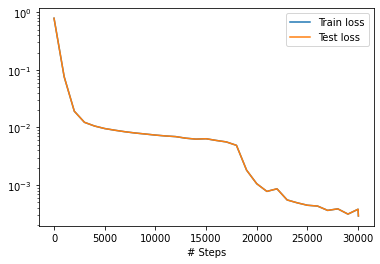

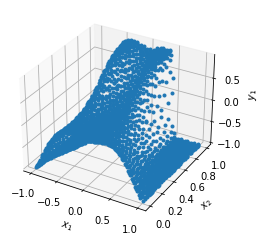

In [ ]:
def train_gpinn(iterations_adam, lr, domain_points, bc_points, ic_points, weights_g):
  geom = dde.geometry.Interval(-1, 1)
  timedomain = dde.geometry.TimeDomain(0, 1)
  geomtime = dde.geometry.GeometryXTime(geom, timedomain)

  data = dde.data.TimePDE(geomtime, pde_gpinn, [], num_domain=domain_points, num_boundary=bc_points, num_initial=ic_points)
  net = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot normal")
  net.apply_output_transform(output_transform_gpinn)
  model_gpinn = dde.Model(data, net)

  weights = [1, weights_g, weights_g]
  model_gpinn.compile("adam", lr=lr, loss_weights=weights)
  model_gpinn.train(iterations=iterations_adam)
  model_gpinn.compile("L-BFGS", loss_weights=weights)
  losshistory, train_state = model_gpinn.train()
  return losshistory, train_state, model_gpinn

losshistory, train_state, model_gpinn = train_gpinn(30000, 1e-3, 2000, 100, 100, 0.0001)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
y_pred = model_gpinn.predict(X)
f = model_gpinn.predict(X, operator=pde_gpinn)[0]
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.0105650285
L2 relative error: 0.11171118878637781


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area.

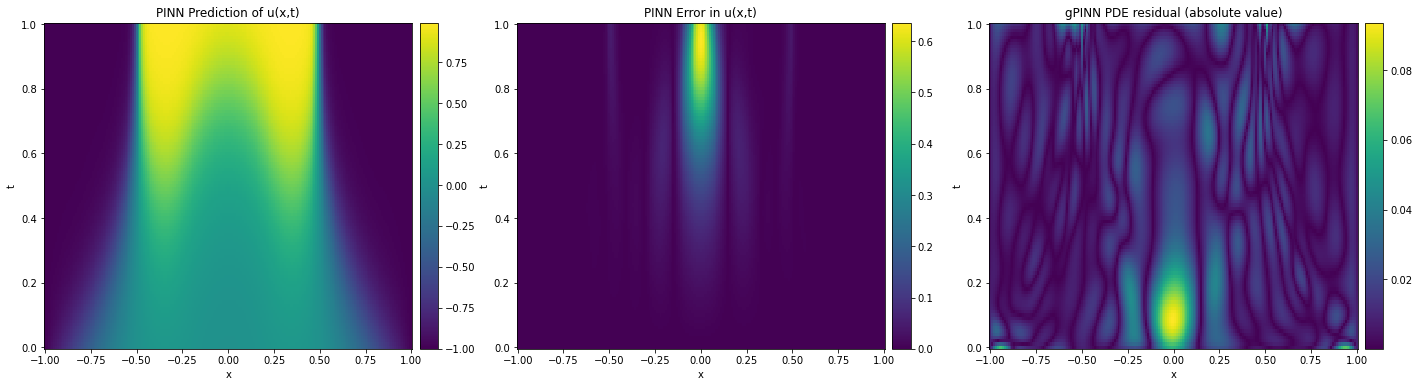

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
axs[0].set_title('PINN Prediction of u(x,t)')
plot1 = axs[0].pcolormesh(x_mesh, t_mesh, y_pred.reshape(x_mesh.shape), cmap='viridis')
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')

axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
axs[1].set_title('PINN Error in u(x,t)')
plot2 = axs[1].pcolormesh(x_mesh, t_mesh, np.absolute(y_true - y_pred).reshape(x_mesh.shape), cmap='viridis')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')

axs[2].set_xlabel('x')
axs[2].set_ylabel('t')
axs[2].set_title('gPINN PDE residual (absolute value)')
plot3 = axs[2].pcolormesh(x_mesh, t_mesh, np.absolute(f).reshape(x_mesh.shape), cmap='viridis')
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot3, cax=cax3, orientation='vertical')

# gPINN with RAR

Here the gPINN is improved with RAR in the same way the PINN was previously improved.

Compiling model...
Building feed-forward neural network...
'build' took 0.076756 s

'compile' took 5.516262 s

Initializing variables...
Training model...

0         [8.02e-01, 5.98e-03, 2.73e-06]    [8.02e-01, 5.98e-03, 2.73e-06]    []  
1000      [6.33e-02, 6.10e-04, 1.52e-04]    [6.33e-02, 6.10e-04, 1.52e-04]    []  
2000      [1.33e-02, 2.14e-04, 4.83e-05]    [1.33e-02, 2.14e-04, 4.83e-05]    []  
3000      [1.02e-02, 1.54e-04, 5.28e-05]    [1.02e-02, 1.54e-04, 5.28e-05]    []  
4000      [9.14e-03, 1.38e-04, 6.97e-05]    [9.14e-03, 1.38e-04, 6.97e-05]    []  
5000      [8.62e-03, 1.30e-04, 9.31e-05]    [8.62e-03, 1.30e-04, 9.31e-05]    []  
6000      [8.35e-03, 1.24e-04, 1.23e-04]    [8.35e-03, 1.24e-04, 1.23e-04]    []  
7000      [8.12e-03, 1.19e-04, 1.50e-04]    [8.12e-03, 1.19e-04, 1.50e-04]    []  
8000      [7.90e-03, 1.13e-04, 1.67e-04]    [7.90e-03, 1.13e-04, 1.67e-04]    []  
9000      [7.85e-03, 1.10e-04, 1.78e-04]    [7.85e-03, 1.10e-04, 1.78e-04]    []  
10000     [7.3

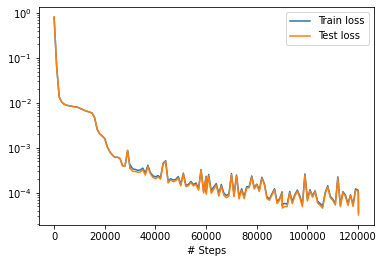

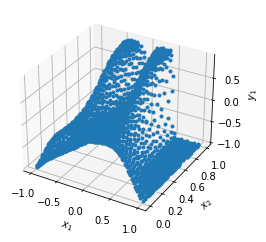

In [ ]:
def train_gpinn_rar(iterations_adam, lr, domain_points, bc_points, ic_points, 
                    weights_g, max_iterations_rar, threshold, m):
  geom = dde.geometry.Interval(-1, 1)
  timedomain = dde.geometry.TimeDomain(0, 1)
  geomtime = dde.geometry.GeometryXTime(geom, timedomain)

  data = dde.data.TimePDE(geomtime, pde_gpinn, [], num_domain=domain_points, num_boundary=bc_points, num_initial=ic_points)
  net = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot normal")
  net.apply_output_transform(output_transform_gpinn)
  model_gpinn_rar = dde.Model(data, net)

  weights = [1, weights_g, weights_g]
  model_gpinn_rar.compile("adam", lr=lr, loss_weights=weights)
  model_gpinn_rar.train(iterations=iterations_adam)
  model_gpinn_rar.compile("L-BFGS", loss_weights=weights)
  losshistory, train_state = model_gpinn_rar.train()

  inputs = geomtime.random_points(10000)
  error = 10
  i = 0
  added_points = np.empty([0, 2])
  while error > threshold and i < max_iterations_rar:
    f_values = model_gpinn_rar.predict(inputs, operator=pde)
    f_abs = np.absolute(f_values)
    error = np.mean(f_abs)
    print("mean error: ", error)

    top_m = np.argsort(f_abs.flatten())[::-1][:m]
    points_to_add = inputs[top_m]
    print("points added: ", points_to_add)
    data.add_anchors(points_to_add)
    added_points = np.vstack((added_points, points_to_add))

    model_gpinn_rar.compile("adam", lr=lr, loss_weights=weights)
    model_gpinn_rar.train(iterations=iterations_adam, disregard_previous_best=True)
    model_gpinn_rar.compile("L-BFGS", loss_weights=weights)
    losshistory, train_state = model_gpinn_rar.train()
    i += 1

  return losshistory, train_state, model_gpinn_rar, added_points

losshistory, train_state, model_gpinn_rar, added_points_gpinn = train_gpinn_rar(30000, 1e-3, 2000, 100, 100, 0.0001, 3, 0.0001, 20)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Calculating the mean PDE residual and the l2 relative error of the model.

In [ ]:
y_pred = model_gpinn_rar.predict(X)
f = model_gpinn_rar.predict(X, operator=pde_gpinn)[0]
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.0036791405
L2 relative error: 0.02338018413495218


Plotting the prediction, the absolute value of the error in the prediction and the PDE residual in each area. In additon, the points that were added during the process are shown in the first plot

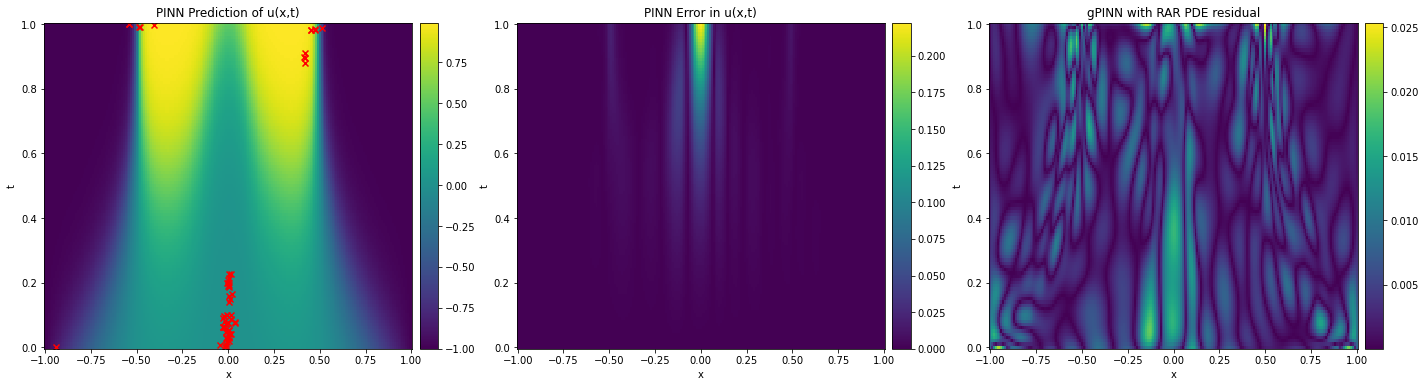

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
axs[0].set_title('PINN Prediction of u(x,t)')
plot1 = axs[0].pcolormesh(x_mesh, t_mesh, y_pred.reshape(x_mesh.shape), cmap='viridis')
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot1, cax=cax1, orientation='vertical')
axs[0].scatter(added_points_gpinn[:, 0], added_points_gpinn[:, 1], color='r', marker='x')

axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
axs[1].set_title('PINN Error in u(x,t)')
plot2 = axs[1].pcolormesh(x_mesh, t_mesh, np.absolute(y_true - y_pred).reshape(x_mesh.shape), cmap='viridis')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot2, cax=cax2, orientation='vertical')

axs[2].set_xlabel('x')
axs[2].set_ylabel('t')
axs[2].set_title('gPINN with RAR PDE residual')
plot3 = axs[2].pcolormesh(x_mesh, t_mesh, np.absolute(f).reshape(x_mesh.shape), cmap='viridis')
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plot3, cax=cax3, orientation='vertical')

# Comparison with different number of training points

Here i trained all the previous models using different number of points inside the domain and just 10000 iterations of Adam. All the models have been evaluated using both the PDE mean residual and the l2 relative error.

In [ ]:
num_domain_points = np.array([100, 200, 400, 600])
pinn_mean_residual = list()
pinn_l2_error = list()
pinn_rar_mean_residual = list()
pinn_rar_l2_error = list()
gpinn_mean_residual = list()
gpinn_l2_error = list()
gpinn_rar_mean_residual = list()
gpinn_rar_l2_error = list()

for domain_points in num_domain_points:
  _, _, model = train_pinn(10000, 1e-3, domain_points, 50, 50)
  pinn_mean_residual.append(np.mean(np.absolute(model.predict(X, operator=pde))))
  pinn_l2_error.append(dde.metrics.l2_relative_error(y_true, model.predict(X)))

  _, _, model_rar, _ = train_rar(10000, 1e-3, domain_points, 50, 50, 3, 0.0001, 20)
  pinn_rar_mean_residual.append(np.mean(np.absolute(model_rar.predict(X, operator=pde))))
  pinn_rar_l2_error.append(dde.metrics.l2_relative_error(y_true, model_rar.predict(X)))

  _, _, model_gpinn = train_gpinn(10000, 1e-3, domain_points, 50, 50, 0.0001)
  gpinn_mean_residual.append(np.mean(np.absolute(model_gpinn.predict(X, operator=pde_gpinn)[0])))
  gpinn_l2_error.append(dde.metrics.l2_relative_error(y_true, model_gpinn.predict(X)))

  _, _, model_gpinn_rar, _ = train_gpinn_rar(10000, 1e-3, domain_points, 50, 50, 0.0001, 3, 0.0001, 20)
  gpinn_rar_mean_residual.append(np.mean(np.absolute(model_gpinn_rar.predict(X, operator=pde_gpinn)[0])))
  gpinn_rar_l2_error.append(dde.metrics.l2_relative_error(y_true, model_gpinn_rar.predict(X)))

Compiling model...
Building feed-forward neural network...
'build' took 0.186959 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.958579 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [6.18e-01]    [6.18e-01]    []  
1000      [2.83e-02]    [2.83e-02]    []  
2000      [1.14e-02]    [1.14e-02]    []  
3000      [8.85e-03]    [8.85e-03]    []  
4000      [7.12e-03]    [7.12e-03]    []  
5000      [6.09e-03]    [6.09e-03]    []  
6000      [4.15e-03]    [4.15e-03]    []  
7000      [3.01e-03]    [3.01e-03]    []  
8000      [2.14e-03]    [2.14e-03]    []  
9000      [1.06e-03]    [1.06e-03]    []  
10000     [8.25e-04]    [8.25e-04]    []  

Best model at step 10000:
  train loss: 8.25e-04
  test loss: 8.25e-04
  test metric: []

'train' took 30.487632 s

Compiling model...
'compile' took 0.629418 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [8.25e-04]    [8.25e-04]    []  
11000     [1.48e-05]    [1.48e-05]        
12000     [5.77e-06]    [5.77e-06]        
13000     [4.12e-06]    [4.12e-06]        
1

Plotting the results obtained for the mean PDE residual and for the l2 relative error

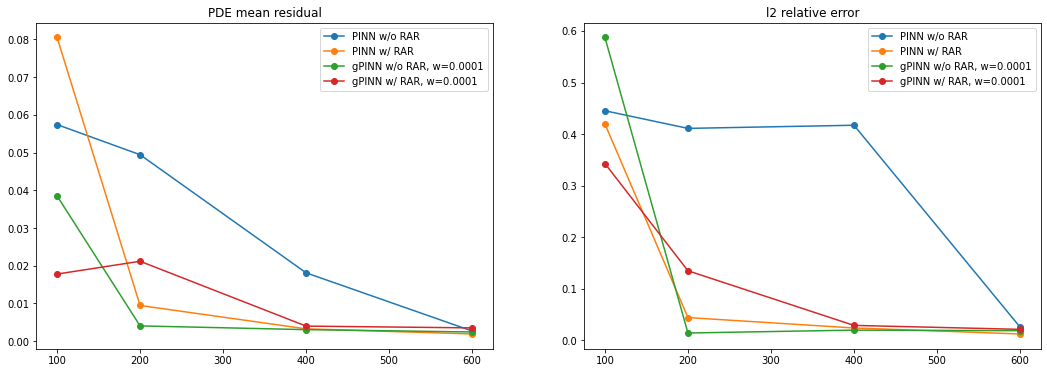

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

axs[0].plot(num_domain_points, np.array(pinn_mean_residual), 'o-', label='PINN w/o RAR')
axs[0].plot(num_domain_points, np.array(pinn_rar_mean_residual), 'o-', label='PINN w/ RAR')
axs[0].plot(num_domain_points, np.array(gpinn_mean_residual), 'o-', label='gPINN w/o RAR, w=0.0001')
axs[0].plot(num_domain_points, np.array(gpinn_rar_mean_residual), 'o-', label='gPINN w/ RAR, w=0.0001')
axs[0].set_title('PDE mean residual')
axs[0].legend()

axs[1].plot(num_domain_points, np.array(pinn_l2_error), 'o-', label='PINN w/o RAR')
axs[1].plot(num_domain_points, np.array(pinn_rar_l2_error), 'o-', label='PINN w/ RAR')
axs[1].plot(num_domain_points, np.array(gpinn_l2_error), 'o-', label='gPINN w/o RAR, w=0.0001')
axs[1].plot(num_domain_points, np.array(gpinn_rar_l2_error), 'o-', label='gPINN w/ RAR, w=0.0001')
axs[1].set_title('l2 relative error')
axs[1].legend()